In [25]:
import numpy as np
from glob import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.linear_model import LogisticRegression
from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [26]:
# Get images' names
non_demented = glob('./data/Non_Demented/*.jpg')
mild_demented = glob('./data/Mild_Demented/*.jpg')
moderate_demented = glob('./data/Moderate_Demented/*.jpg')
very_mild_demented = glob('./data/Very_Mild_Demented/*.jpg')
num_classes = 4
image_size = (108,108)

In [58]:
def view_image(filename):
    img = mpimg.imread(filename)
    img = img[10:118, 10:118]
    plt.imshow(img)
    print(f'Image shape: {img.shape}')


Total amount of non_demented: 3200
Image shape: (108, 108)


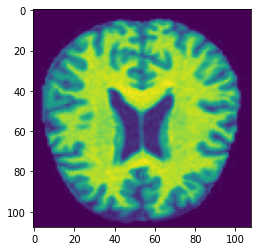

In [59]:
print(f'Total amount of non_demented: {len(non_demented)}')
view_image(non_demented[0])

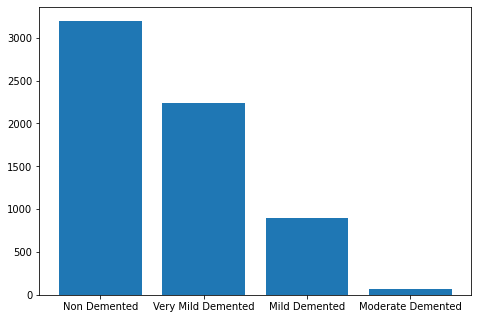

In [23]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = [len(non_demented), len(very_mild_demented), len(mild_demented), len(moderate_demented)]
class_names = ['Non Demented', 'Very Mild Demented', 'Mild Demented', 'Moderate Demented']
ax.bar(class_names,size)
plt.show()

In [24]:
np.set_printoptions(threshold=np.inf)
def extract_feature(dir_path):
    img = mpimg.imread(dir_path)
    img = img[10:118, 10:118] # photoshopping some values to avoid GPU going brrr
    img = img / 255.0  # normalize pixel values
    print(img.shape)
    img = resize(img, (128, 128, 3))  # convert all images to (128x128x3)
    return img

print(extract_feature("data/Non_Demented/non.jpg"))
# all_data =  np.array([extract_feature(filename) for filename in non_demented] + \
#             [extract_feature(filename) for filename in mild_demented] + \
#             [extract_feature(filename) for filename in moderate_demented] + \
#             [extract_feature(filename) for filename in very_mild_demented])
# y = np.array([0] * len(non_demented) + [1] * len(mild_demented) + [2] * len(moderate_demented) + [3] * len(very_mild_demented))
# X_train, X_rem, y_train, y_rem = train_test_split(all_data, y, train_size = 0.8)
# X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, train_size = 0.5)
# print(f"Length of training set: {len(X_train)}")
# print(f"Length of validation set: {len(X_valid)}")
# print(f"Length of test set: {len(X_test)}")

(128, 128)
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.   

In [36]:
# SVM


In [22]:
# Neural Networks (CNN)
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

MRI_model = Sequential()
MRI_model.add()

In [14]:
# Logistic Regression

# Some activation functions

def cost():
    pass 

# print(X_train.shape)
# print(X_valid.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_valid.shape)
# print(y_test.shape)

(5120, 128, 384)
(640, 128, 384)
(640, 128, 384)
(5120,)
(640,)
(640,)


In [39]:
# For fun, PCA

In [ ]:
# FOR EVEN MORE FUN, get the average brain scan